# 상위 100명의 선호도 정보 저장

In [1]:
import pandas as pd

def _df_load(path, state='train'):
    df = pd.read_csv(path)
    df_count = df.groupby(['응답자 ID']).size()
    df_count.name = f'{state} 설문 응답 수'

    return df, df_count

def _top100_filtering(df, top100_ids, state='train', save=True):
    top100_df = df[df['응답자 ID'].isin(top100_ids)].reset_index(drop=True)
    if save:
        top100_df.to_csv(f'top100_{state}_preference.csv', index=False)
    
    return top100_df

def make_top100_csv(train_csv, val_csv, save=True):
    # csv 파일로부터 데이터 불러오기
    df_train, train_count = _df_load(train_csv, 'train')
    df_val, val_count = _df_load(val_csv, 'val')

    # 몇 가지 전처리
    df_sum = pd.concat([train_count, val_count],axis=1)
    df_sum = df_sum.fillna(0).astype(int)    # 결측치 0으로 채우기
    df_sum['합계'] = df_sum['train 설문 응답 수'] + df_sum['val 설문 응답 수']    # '합계' 열 추가
    df_sum = df_sum.sort_values(by='합계', ascending=False)    # '합계' 열 기준으로 내림차순 정렬

    # df_sum의 합계를 기준으로 상위 100개 응답자 ID 추출하여 리스트로 저장
    top100_ids = df_sum.head(100).index.tolist()

    # 상위 100개의 유효한 응답자 ID를 가진 데이터만 추출
    top100_train_df = _top100_filtering(df_train, top100_ids, 'train', save=save)
    top100_val_df = _top100_filtering(df_val, top100_ids, 'val', save=save)

    return top100_train_df, top100_val_df


# Mission 2-2에서 생성한 csv 파일의 경로
t_pref = 'train_preference.csv'
v_pref = 'val_preference.csv'

#t_top100_pref, v_top100_pref = make_top100_csv(t_pref, v_pref, save=True)

In [2]:
# 결과 보기 좋게 HTML편집
from IPython.display import display_html
def display_left(*args):
    html_str = ''
    for df in args:
        html_str += f'<div style="margin-right:30px;">{df.to_html()}</div>'
    display_html(f'<div style="display: flex;">{html_str}</div>', raw=True)

# 데이터 결과 미리 확인
display_left(t_top100_pref.head(), v_top100_pref.head())

,응답자 ID,파일명,스타일 선호 여부
0,368,W_06753_60_mods_M.jpg,스타일 선호
1,368,W_06686_70_hippie_M.jpg,스타일 선호
2,368,W_15453_70_hippie_M.jpg,스타일 비선호
3,368,W_06843_60_mods_M.jpg,스타일 선호
4,368,W_06896_10_sportivecasual_M.jpg,스타일 선호
,응답자 ID,파일명,스타일 선호 여부
0,368,W_04622_60_mods_M.jpg,스타일 선호
1,368,W_04678_50_ivy_M.jpg,스타일 선호
2,368,W_15791_70_hippie_M.jpg,스타일 비선호
3,368,W_16034_80_bold_M.jpg,스타일 비선호


# train data로부터 feature vector 추출

In [1]:
# 필요 패키지 import 
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms


# 모델 재현을 위한 랜덤시드 고정
def set_random_seed(seed_value=42):
    # Python의 기본 난수 시드 설정
    random.seed(seed_value)
    # NumPy 난수 시드 설정
    np.random.seed(seed_value)
    # PyTorch 난수 시드 설정 (CPU)
    torch.manual_seed(seed_value)
    # PyTorch 난수 시드 설정 (GPU)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    # CuDNN 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

In [2]:
import torchvision.models as models

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 학습된 가중치로 모델 불러오기
model = models.resnet18(weights=None, num_classes=31)
model.load_state_dict(torch.load('./best_model.pth', weights_only=True))    # 가중치 로드
model = model.to(device)
model.eval()    # 학습을 하는 것이 아니므로 eval 모드로 설정

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# 특징 추출을 위한 Class 선언
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])    # 마지막 fc layer 제외
    
    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)

feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)

In [4]:
# 이미지 전처리 함수(모델 학습 시 적용한 전처리와 동일하게 적용)
def _preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)    # 배치 차원 추가

# feature vector 추출 함수
def _extract_features(image_path):
    
    image = _preprocess_image(image_path).to(device)
    with torch.no_grad():
        features = feature_extractor(image)
    return features.cpu().numpy().flatten()

# 여러 이미지로부터 feature vector 추출
def extract_features_from_images(dir_path, image_list):
    features = {}
    for img in image_list:
        path = os.path.join(dir_path, img)
        feature = _extract_features(path)
        features[img] = np.array(feature)
    return features

In [5]:
def extract_and_save(state='train', save=True):
    img_path = '../resized_data'
    if state == 'train':
        dir_path = os.path.join(img_path, 'training_image')
    else:
        dir_path = os.path.join(img_path, 'validation_image')
    img_list = os.listdir(dir_path)

    extracted_features = extract_features_from_images(dir_path, img_list)

    # feature의 shape 확인(fc layer 이전은 512개의 feature)
    print(f"이미지 수: {len(extracted_features)}, feature shape: {extracted_features[img_list[0]].shape}")

    # 추출된 feature vector를 DataFrame으로 변환 후 저장
    feature_vectors = pd.DataFrame(extracted_features).T
    if save:
        feature_vectors.to_csv(f'{state}_feature_vectors.csv')
    
    return feature_vectors

# feature vector 추출 및 저장
t_feature_vectors = extract_and_save('train', save=True)
v_feature_vectors = extract_and_save('val', save=True)

이미지 수: 4070, feature shape: (512,)
이미지 수: 951, feature shape: (512,)


# 이미지 유사도를 활용한 스타일 선호 예측

In [1]:
import numpy as np
import pandas as pd

# top100 선호도 데이터 로드
t_top100_pref = pd.read_csv('top100_train_preference.csv')
v_top100_pref = pd.read_csv('top100_val_preference.csv')

# 선호도 여부를 0과 1로 변환
t_top100_pref['스타일 선호 여부'] = t_top100_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else 0)
v_top100_pref['스타일 선호 여부'] = v_top100_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else 0)

In [2]:
def feature_preprocessing(csv_path):
    feature_vectors = pd.read_csv(csv_path, index_col=0)        # feature vector 데이터 불러오기
    feature_vectors['feature_vector'] = feature_vectors.values.tolist()      # 512차원의 feature vector를 하나의 list로 변환

    # '파일명'과 'feature_vector' 열만 남기기
    feature_reset = feature_vectors.reset_index().rename(columns={'index': '파일명'})
    feature_simplified = feature_reset[['파일명', 'feature_vector']]

    return feature_simplified

# 저장된 feature vector csv 파일 경로
t_feature_simplified = feature_preprocessing('train_feature_vectors.csv')
v_feature_simplified = feature_preprocessing('val_feature_vectors.csv')

In [3]:
# train과 validation 데이터의 feature vector를 이용하여 유사도 행렬 생성
from sklearn.metrics.pairwise import cosine_similarity

# feature_vectors를 numpy 배열로 변환
train_features = np.stack(t_feature_simplified['feature_vector'].values)
val_features = np.stack(v_feature_simplified['feature_vector'].values)

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(train_features, val_features)

# 결과를 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix, 
                             index=t_feature_simplified['파일명'],
                             columns=v_feature_simplified['파일명'])

similarity_df

파일명,T_00253_60_popart_W.jpg,T_00456_10_sportivecasual_M.jpg,T_01123_90_hiphop_M.jpg,T_01514_50_ivy_M.jpg,T_06910_50_classic_W.jpg,T_07990_60_mods_M.jpg,T_14538_00_cityglam_W.jpg,T_21986_70_hippie_M.jpg,T_21988_70_hippie_M.jpg,T_21992_70_hippie_M.jpg,...,W_60553_00_cityglam_W.jpg,W_61255_00_cityglam_W.jpg,W_61790_10_sportivecasual_W.jpg,W_62253_19_lounge_W.jpg,W_62313_00_oriental_W.jpg,W_63188_90_kitsch_W.jpg,W_63644_10_sportivecasual_M.jpg,W_64047_10_sportivecasual_W.jpg,W_64332_80_powersuit_W.jpg,W_65122_10_sportivecasual_W.jpg
파일명,,,,,,,,,,,,,,,,,,,,,
T_00253_60_popart_W.jpg,1.000000,0.356601,0.407077,0.256626,0.391643,0.311999,0.433721,0.435874,0.573327,0.566454,...,0.487305,0.404429,0.438776,0.693745,0.817572,0.590240,0.375380,0.505721,0.366120,0.329193
T_00456_10_sportivecasual_M.jpg,0.356601,1.000000,0.607903,0.482551,0.458442,0.824572,0.365585,0.603676,0.551143,0.619612,...,0.354743,0.416745,0.686484,0.529971,0.352036,0.464068,0.953669,0.614423,0.384840,0.641965
T_00588_10_sportivecasual_M.jpg,0.404470,0.931685,0.674157,0.527290,0.545047,0.856895,0.447968,0.623773,0.643511,0.633101,...,0.437665,0.481001,0.669362,0.606319,0.404659,0.475907,0.919181,0.609248,0.440411,0.620798
T_00770_60_minimal_W.jpg,0.296947,0.301615,0.480528,0.534045,0.577348,0.413165,0.501668,0.309781,0.368881,0.267684,...,0.451353,0.520059,0.420540,0.576524,0.345642,0.348688,0.281055,0.472665,0.573156,0.501972
T_00893_90_hiphop_W.jpg,0.437143,0.581880,0.494998,0.476488,0.546915,0.518444,0.705758,0.618199,0.638134,0.614239,...,0.718388,0.809460,0.673774,0.563499,0.521721,0.559015,0.675618,0.582345,0.387753,0.603552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_71923_60_mods_M.jpg,0.159016,0.407654,0.761460,0.903910,0.748548,0.466943,0.316784,0.417974,0.504463,0.310361,...,0.256006,0.286834,0.207616,0.391517,0.237789,0.430893,0.408533,0.237156,0.503248,0.268850
W_71933_60_mods_M.jpg,0.151220,0.464717,0.757028,0.863834,0.740558,0.469634,0.321724,0.461533,0.511597,0.353029,...,0.256392,0.277750,0.221895,0.378370,0.241371,0.468661,0.461320,0.239553,0.519141,0.287274
W_71934_60_mods_M.jpg,0.163003,0.453442,0.718272,0.896758,0.769507,0.451545,0.353960,0.421273,0.526195,0.321960,...,0.289377,0.335987,0.267999,0.394457,0.247570,0.457238,0.457311,0.285461,0.530515,0.349319


기본 통계:
평균: 0.5299
중앙값: 0.5182
표준편차: 0.1478
최소값: 0.1121
최대값: 1.0000


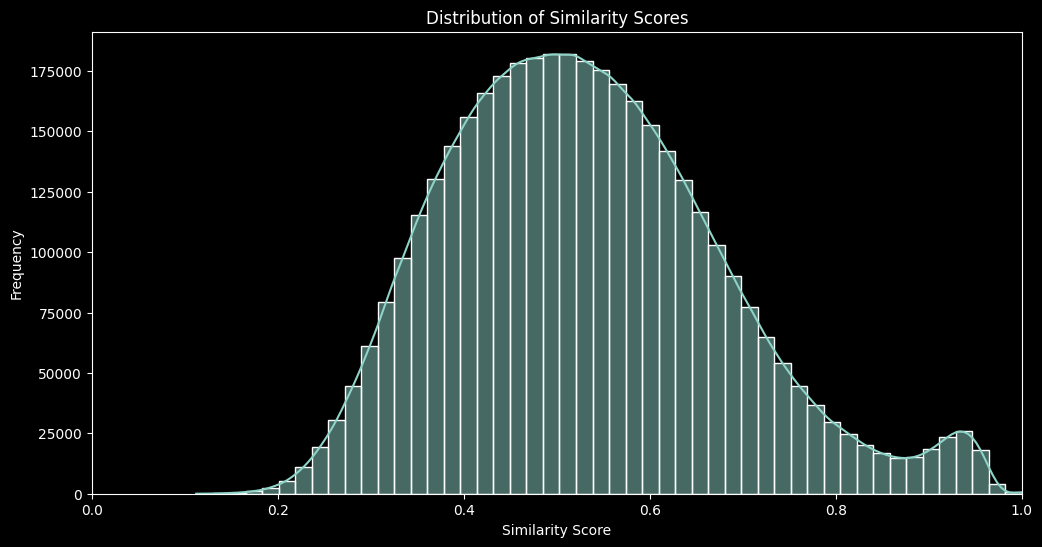

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모든 유사도 값을 1차원 배열로 변환
similarity_values = similarity_df.values.flatten()

# 기본 통계 출력
print("기본 통계:")
print(f"평균: {similarity_values.mean():.4f}")
print(f"중앙값: {np.median(similarity_values):.4f}")
print(f"표준편차: {similarity_values.std():.4f}")
print(f"최소값: {similarity_values.min():.4f}")
print(f"최대값: {similarity_values.max():.4f}")

# 그래프 설정
plt.figure(figsize=(12, 6))

# 히스토그램과 밀도 플롯 그리기
sns.histplot(similarity_values, kde=True, bins=50)

plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")

# x축 범위 설정
plt.xlim(0, 1)
plt.show()

## (1) 유사도 top1의 item만 고려하여 예측

In [5]:
# 유사도가 가장 높은 item의 선호도를 바탕으로 예측
def _method1(top_similar_items, user_rated_df):
    predicted_rating = user_rated_df.loc[user_rated_df['파일명'] == top_similar_items.index[0]]['스타일 선호 여부'].values[0]
    return predicted_rating


def predict_preference(v_top100_pref, t_top100_pref, similarity_df):
    pred_list = []

    for i in range(len(v_top100_pref)):
        userID = v_top100_pref.iloc[i, 0]
        item = v_top100_pref.iloc[i, 1]

        # userID를 기준으로 해당 유저가 이미 평가한 items의 정보
        user_rated_df = t_top100_pref.loc[t_top100_pref['응답자 ID'] == userID]
        rated_items = user_rated_df['파일명'].values
        
        # 해당 유저가 이미 평가한 아이템들과 item의 유사도 추출
        similar_items = similarity_df.loc[rated_items, item]

        # 유사도가 가장 높은 item 추출
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items.head(1)

        # 선호도 예측
        predicted_rating = _method1(top_similar_items, user_rated_df)

        # 예측값 저장
        pred_list.append([userID, item, predicted_rating])

    pred_df = pd.DataFrame(pred_list, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return pred_df

# 선호도 예측
pred_df = predict_preference(v_top100_pref, t_top100_pref, similarity_df)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1
1,368,W_16848_19_normcore_M.jpg,0
2,368,W_06864_10_sportivecasual_M.jpg,0
3,368,W_15340_50_ivy_M.jpg,0
4,368,W_16034_80_bold_M.jpg,0
...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0
1096,67975,W_06985_00_metrosexual_M.jpg,1
1097,67975,T_21992_70_hippie_M.jpg,0
1098,67975,T_21988_70_hippie_M.jpg,1


In [6]:
# v_top100_pref와 merge
merge_df = v_top100_pref.merge(pred_df, on=['응답자 ID', '파일명'], how='left')

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
precision = precision_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
recall = recall_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

merge_df

Accuracy: 0.8445, Precision: 0.7848, Recall: 0.8435


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,1
1,368,W_16848_19_normcore_M.jpg,0,0
2,368,W_06864_10_sportivecasual_M.jpg,1,0
3,368,W_15340_50_ivy_M.jpg,0,0
4,368,W_16034_80_bold_M.jpg,0,0
...,...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0,0
1096,67975,W_06985_00_metrosexual_M.jpg,0,1
1097,67975,T_21992_70_hippie_M.jpg,0,0
1098,67975,T_21988_70_hippie_M.jpg,1,1


## (2) 유사도가 높은 7개 items의 선호도를 voting
> - 5개로 voting하면 max와 결과가 동일함
> - 9개로 늘리면 성능이 더 떨어짐

In [7]:
# 유사도 상위 7개 items의 선호도를 바탕으로 voting하여 예측
def _method2(top_similar_items, user_rated_df):
    pref_lists = []
    for similar_item in top_similar_items.index:
        rating = user_rated_df.loc[user_rated_df['파일명']==similar_item]['스타일 선호 여부'].values[0]
        pref_lists.append(rating)
    # pref_lists에서 개수가 가장 많은 선호도를 값을 예측으로 사용
    predicted_rating = max(pref_lists, key=pref_lists.count)

    return predicted_rating


def predict_preference(v_top100_pref, t_top100_pref, similarity_df):
    pred_list = []

    for i in range(len(v_top100_pref)):
        userID = v_top100_pref.iloc[i, 0]
        item = v_top100_pref.iloc[i, 1]

        # userID를 기준으로 해당 유저가 이미 평가한 items의 정보
        user_rated_df = t_top100_pref.loc[t_top100_pref['응답자 ID'] == userID]
        rated_items = user_rated_df['파일명'].values
        
        # 해당 유저가 이미 평가한 아이템들과 item의 유사도 추출
        similar_items = similarity_df.loc[rated_items, item]

        # 유사도 상위 7개의 item 추출
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items.head(7)

        # 선호도 예측
        predicted_rating = _method2(top_similar_items, user_rated_df)

        # 예측값 저장
        pred_list.append([userID, item, predicted_rating])

    pred_df = pd.DataFrame(pred_list, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return pred_df

# 선호도 예측
pred_df = predict_preference(v_top100_pref, t_top100_pref, similarity_df)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1
1,368,W_16848_19_normcore_M.jpg,0
2,368,W_06864_10_sportivecasual_M.jpg,1
3,368,W_15340_50_ivy_M.jpg,1
4,368,W_16034_80_bold_M.jpg,0
...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0
1096,67975,W_06985_00_metrosexual_M.jpg,1
1097,67975,T_21992_70_hippie_M.jpg,0
1098,67975,T_21988_70_hippie_M.jpg,0


In [8]:
# v_top100_pref와 merge
merge_df = v_top100_pref.merge(pred_df, on=['응답자 ID', '파일명'], how='left')

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
precision = precision_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
recall = recall_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

merge_df

Accuracy: 0.6909, Precision: 0.6241, Recall: 0.5760


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,1
1,368,W_16848_19_normcore_M.jpg,0,0
2,368,W_06864_10_sportivecasual_M.jpg,1,1
3,368,W_15340_50_ivy_M.jpg,0,1
4,368,W_16034_80_bold_M.jpg,0,0
...,...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0,0
1096,67975,W_06985_00_metrosexual_M.jpg,0,1
1097,67975,T_21992_70_hippie_M.jpg,0,0
1098,67975,T_21988_70_hippie_M.jpg,1,0


## (3) 가중 평균을 사용하여 예측

In [9]:
# 강의에서 사용한 방법(top_similar_items의 유사도에 사용자 평점을 가중 평균하여 예측 평점 계산)
def _method3(top_similar_items, user_rated_df):
    weighted_ratings_sum = 0    # 가중 평점의 합(분자)
    similarity_sum = 0          # 모든 유사도의 합(분모)

    # 사용자가 평가한 아이템 중 top_similar_items를 고려하여 선호도 예측
    for similar_item in top_similar_items.index:
        similarity = top_similar_items[similar_item]
        rating = user_rated_df.loc[user_rated_df['파일명'] == similar_item]['스타일 선호 여부'].values[0]
        weighted_ratings_sum += similarity * rating
        similarity_sum += similarity

    if similarity_sum != 0:
        predicted_rating = weighted_ratings_sum / similarity_sum
    else:
        predicted_rating = 0

    return predicted_rating


def predict_preference(v_top100_pref, t_top100_pref, similarity_df):
    pred_list = []

    for i in range(len(v_top100_pref)):
        userID = v_top100_pref.iloc[i, 0]
        item = v_top100_pref.iloc[i, 1]

        # userID를 기준으로 해당 유저가 이미 평가한 items의 정보
        user_rated_df = t_top100_pref.loc[t_top100_pref['응답자 ID'] == userID]
        rated_items = user_rated_df['파일명'].values
        
        # 해당 유저가 이미 평가한 아이템들과 item의 유사도 추출
        similar_items = similarity_df.loc[rated_items, item]

        # 유사도가 임계값 이상인 항목들만 추출(!임계값 변경 가능)
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items[similar_items >= 0.7]    # 임계값: 0.7

        # 선호도 예측(강의에서 사용한 방법 사용)
        predicted_rating = _method3(top_similar_items, user_rated_df)

        # 예측값 저장
        pred_list.append([userID, item, predicted_rating])

    pred_df = pd.DataFrame(pred_list, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return pred_df

# 선호도 예측
pred_df = predict_preference(v_top100_pref, t_top100_pref, similarity_df)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,0.673021
1,368,W_16848_19_normcore_M.jpg,0.384324
2,368,W_06864_10_sportivecasual_M.jpg,0.000000
3,368,W_15340_50_ivy_M.jpg,0.660546
4,368,W_16034_80_bold_M.jpg,0.263832
...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0.167989
1096,67975,W_06985_00_metrosexual_M.jpg,0.523059
1097,67975,T_21992_70_hippie_M.jpg,0.298040
1098,67975,T_21988_70_hippie_M.jpg,0.424611


< 기본 통계 >
개수: 1100 | 평균: 0.3998 | 중앙값: 0.3990 | 표준편차: 0.2562


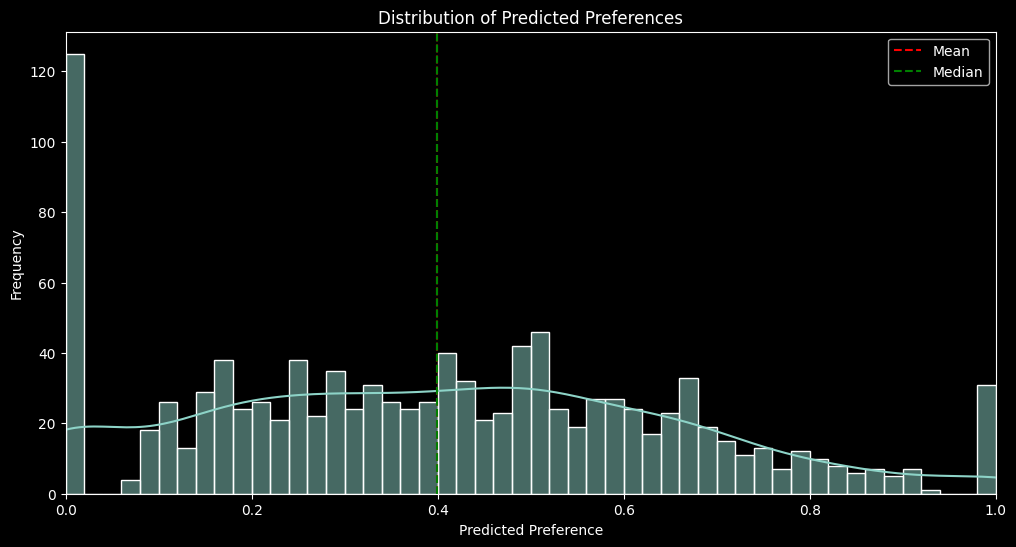

In [10]:
# 예측된 선호도를 결정할 임계값 계산을 위한 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 기본 통계 계산
stats = pred_df['예측된 선호도'].describe()

# 기본 통계 출력
print("< 기본 통계 >")
print(f"개수: {stats['count']:.0f} | 평균: {stats['mean']:.4f} | 중앙값: {stats['50%']:.4f} | 표준편차: {stats['std']:.4f}")


# 그래프 설정
plt.figure(figsize=(12, 6))

# 히스토그램과 KDE 플롯
sns.histplot(data=pred_df, x='예측된 선호도', kde=True, bins=50)

# 평균과 중앙값 표시
plt.axvline(stats['mean'], color='r', linestyle='--', label='Mean')
plt.axvline(stats['50%'], color='g', linestyle='--', label='Median')

plt.title("Distribution of Predicted Preferences")
plt.xlabel("Predicted Preference")
plt.ylabel("Frequency")
plt.legend()

# x축 범위 설정
plt.xlim(0, 1)

plt.show()

In [11]:
# pred_df의 값이 0.5 이상인 경우 '스타일 선호'로 분류
pred_df['예측된 선호도'] = pred_df['예측된 선호도'].apply(lambda x: 1 if x >= 0.5 else 0)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1
1,368,W_16848_19_normcore_M.jpg,0
2,368,W_06864_10_sportivecasual_M.jpg,0
3,368,W_15340_50_ivy_M.jpg,1
4,368,W_16034_80_bold_M.jpg,0
...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0
1096,67975,W_06985_00_metrosexual_M.jpg,1
1097,67975,T_21992_70_hippie_M.jpg,0
1098,67975,T_21988_70_hippie_M.jpg,0


In [12]:
# v_top100_pref와 merge
merge_df = v_top100_pref.merge(pred_df, on=['응답자 ID', '파일명'], how='left')

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
precision = precision_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
recall = recall_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

merge_df

Accuracy: 0.7118, Precision: 0.6582, Recall: 0.5850


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,1
1,368,W_16848_19_normcore_M.jpg,0,0
2,368,W_06864_10_sportivecasual_M.jpg,1,0
3,368,W_15340_50_ivy_M.jpg,0,1
4,368,W_16034_80_bold_M.jpg,0,0
...,...,...,...,...
1095,67975,W_26965_90_hiphop_M.jpg,0,0
1096,67975,W_06985_00_metrosexual_M.jpg,0,1
1097,67975,T_21992_70_hippie_M.jpg,0,0
1098,67975,T_21988_70_hippie_M.jpg,1,0


## (부록) feature vector가 비슷한 이미지는 진짜 비슷할까?

In [13]:
# train과 validation 이미지의 feature vector 기반 유사도 행렬
similarity_df

파일명,T_00253_60_popart_W.jpg,T_00456_10_sportivecasual_M.jpg,T_01123_90_hiphop_M.jpg,T_01514_50_ivy_M.jpg,T_06910_50_classic_W.jpg,T_07990_60_mods_M.jpg,T_14538_00_cityglam_W.jpg,T_21986_70_hippie_M.jpg,T_21988_70_hippie_M.jpg,T_21992_70_hippie_M.jpg,...,W_60553_00_cityglam_W.jpg,W_61255_00_cityglam_W.jpg,W_61790_10_sportivecasual_W.jpg,W_62253_19_lounge_W.jpg,W_62313_00_oriental_W.jpg,W_63188_90_kitsch_W.jpg,W_63644_10_sportivecasual_M.jpg,W_64047_10_sportivecasual_W.jpg,W_64332_80_powersuit_W.jpg,W_65122_10_sportivecasual_W.jpg
파일명,,,,,,,,,,,,,,,,,,,,,
T_00253_60_popart_W.jpg,1.000000,0.356601,0.407077,0.256626,0.391643,0.311999,0.433721,0.435874,0.573327,0.566454,...,0.487305,0.404429,0.438776,0.693745,0.817572,0.590240,0.375380,0.505721,0.366120,0.329193
T_00456_10_sportivecasual_M.jpg,0.356601,1.000000,0.607903,0.482551,0.458442,0.824572,0.365585,0.603676,0.551143,0.619612,...,0.354743,0.416745,0.686484,0.529971,0.352036,0.464068,0.953669,0.614423,0.384840,0.641965
T_00588_10_sportivecasual_M.jpg,0.404470,0.931685,0.674157,0.527290,0.545047,0.856895,0.447968,0.623773,0.643511,0.633101,...,0.437665,0.481001,0.669362,0.606319,0.404659,0.475907,0.919181,0.609248,0.440411,0.620798
T_00770_60_minimal_W.jpg,0.296947,0.301615,0.480528,0.534045,0.577348,0.413165,0.501668,0.309781,0.368881,0.267684,...,0.451353,0.520059,0.420540,0.576524,0.345642,0.348688,0.281055,0.472665,0.573156,0.501972
T_00893_90_hiphop_W.jpg,0.437143,0.581880,0.494998,0.476488,0.546915,0.518444,0.705758,0.618199,0.638134,0.614239,...,0.718388,0.809460,0.673774,0.563499,0.521721,0.559015,0.675618,0.582345,0.387753,0.603552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_71923_60_mods_M.jpg,0.159016,0.407654,0.761460,0.903910,0.748548,0.466943,0.316784,0.417974,0.504463,0.310361,...,0.256006,0.286834,0.207616,0.391517,0.237789,0.430893,0.408533,0.237156,0.503248,0.268850
W_71933_60_mods_M.jpg,0.151220,0.464717,0.757028,0.863834,0.740558,0.469634,0.321724,0.461533,0.511597,0.353029,...,0.256392,0.277750,0.221895,0.378370,0.241371,0.468661,0.461320,0.239553,0.519141,0.287274
W_71934_60_mods_M.jpg,0.163003,0.453442,0.718272,0.896758,0.769507,0.451545,0.353960,0.421273,0.526195,0.321960,...,0.289377,0.335987,0.267999,0.394457,0.247570,0.457238,0.457311,0.285461,0.530515,0.349319


In [15]:
# "T_00253_60_popart_W.jpg" 이미지와 유사도가 높은 이미지
similarity_df.iloc[:, 0].sort_values(ascending=False)

파일명
T_00253_60_popart_W.jpg    1.000000
W_19838_60_popart_W.jpg    0.975516
W_19537_60_popart_W.jpg    0.963672
W_19412_60_popart_W.jpg    0.961021
W_04994_60_popart_W.jpg    0.954931
                             ...   
W_33002_60_mods_M.jpg      0.131385
W_00017_60_mods_M.jpg      0.129835
W_01726_60_mods_M.jpg      0.127617
W_15295_60_mods_M.jpg      0.125664
W_16051_60_mods_M.jpg      0.123859
Name: T_00253_60_popart_W.jpg, Length: 4070, dtype: float64

> 실제로 이미지 파일을 살펴보면 상당히 비슷하게 생겼음을 알 수 있다.